In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))

In [2]:
import numpy as np
from scipy.special import comb
from itertools import product
import GPlib

def generate_grids(d = 1, num_grids = 50, grids_lim = (-1, 1), random = False):
    # Define the base grids based on random or sequential generation
    if random:
        base_grids = np.random.rand(num_grids) * (grids_lim[1] - grids_lim[0]) + grids_lim[0]
    else:
        base_grids = np.linspace(grids_lim[0], grids_lim[1], num_grids)

    # Create list of grids for each dimension
    grids_list = [base_grids] * d

    # Generate all combinations using product and convert to tensor
    grids = np.array(list(product(*grids_list)), dtype = np.float64)

    # Reshape to match R's expand.grid output
    grids = np.flip(grids, axis = 1)

    return grids

def gp_eigen_value(poly_degree=10, a=1, b=1, d=2):
    # Calculate constants
    cn = np.sqrt(a**2 + 2*a*b)
    A = a + b + cn
    B = b / A

    # Create index array (equivalent to R's c() and choose())
    idx = np.array([0] + [comb(i + d, d, exact=True) for i in range(poly_degree + 1)])

    # Generate idxlist using list comprehension (equivalent to R's sapply)
    idxlist = [list(range(idx[i] + 1, idx[i + 1] + 1)) for i in range(poly_degree + 1)]

    # Get length k from external function (assumed to be defined elsewhere)
    k = gp_num_eigen_funs(poly_degree=poly_degree, d=d)

    # Initialize value array with NaN
    value = np.full(k, np.nan)

    # Calculate dvalue
    dvalue = (np.sqrt(np.pi / A))**d * B**np.arange(1, poly_degree + 2)

    # Fill value array using idxlist
    for i in range(poly_degree + 1):
        # Convert to 0-based indexing for Python (R uses 1-based)
        indices = [x - 1 for x in idxlist[i]]
        value[indices] = dvalue[i]

    return value

def gp_num_eigen_funs(poly_degree = 10, d = 2):
    return int(comb(poly_degree + d, d))

def gp_eigen_funcs_fast(grids, poly_degree = 10, a = 0.01, b = 1.0, orth = False):
    num_funcs = gp_num_eigen_funs(poly_degree, grids.shape[1])
    eigen_funcs = np.zeros(num_funcs * grids.shape[0], dtype = np.float64)
    grids_size = grids.shape[0]
    d = grids.shape[1]
    grids = grids.reshape(-1, order = "F")
    if orth == True:
        res = GPlib.GP_eigen_funcs_orth(eigen_funcs, grids, int(grids_size), int(d), int(poly_degree), float(a), float(b))
    else:
        res = GPlib.GP_eigen_funcs(eigen_funcs, grids, int(grids_size), int(d), int(poly_degree), float(a), float(b))
    return res.reshape((grids_size, num_funcs), order = "F")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_gp_eigen_funcs(grids, eigen_funcs):
    grids_size, num_funcs = eigen_funcs.shape
    print(f'grids_size={grids_size} num_funcs={num_funcs}') 

    if grids.shape[1] == 1:  # 1D Case
        x = grids.flatten()
        plt.figure(figsize=(10, 6))
        for i in range(min(5, num_funcs)):  # Plot first 5 functions
            plt.plot(x, eigen_funcs[:, i], label=f'Eigenfunction {i+1}')
        plt.xlabel('Grid Points')
        plt.ylabel('Function Value')
        plt.title('Gaussian Process Eigenfunctions (1D)')
        plt.legend()
        plt.show()

    elif grids.shape[1] == 2:  # 2D Case
        fig, axes = plt.subplots(1, min(5, num_funcs), figsize=(15, 5))
        x, y = grids[:, 0], grids[:, 1]
        for i in range(min(5, num_funcs)):  # Plot first 5 eigenfunctions
            ax = axes[i] if num_funcs > 1 else axes
            sc = ax.scatter(x, y, c=eigen_funcs[:, i], cmap='coolwarm', marker='o')
            ax.set_title(f'Eigenfunction {i+1}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            fig.colorbar(sc, ax=ax)
        plt.tight_layout()
        plt.show()

    else:
        print("Visualization is currently supported for 1D and 2D grids.")


grids_size=10 num_funcs=11


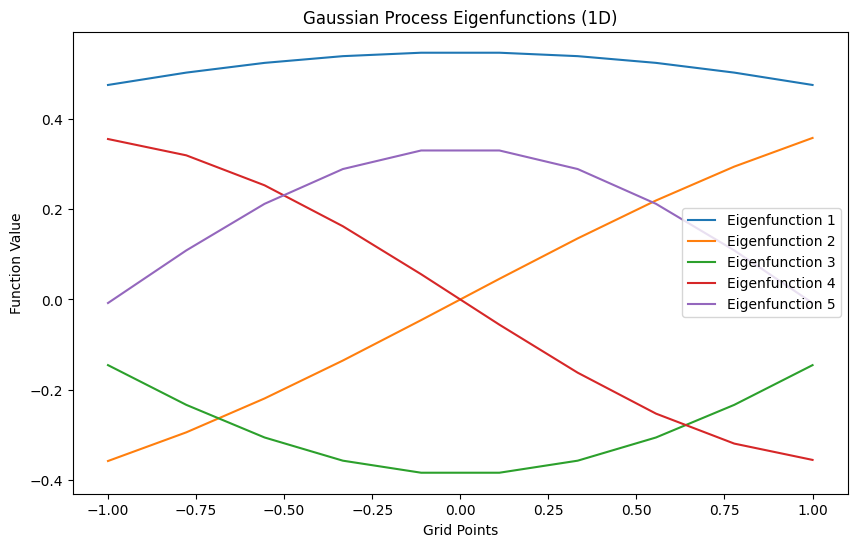

In [4]:
grids_1d = generate_grids(d = 1, num_grids = 10, grids_lim = (-1, 1), random = False)
eigen_funcs_1d = gp_eigen_funcs_fast(grids_1d)
visualize_gp_eigen_funcs(grids_1d, eigen_funcs_1d)

(100, 2) <class 'numpy.ndarray'>
(100, 66) <class 'numpy.ndarray'>
grids_size=100 num_funcs=66


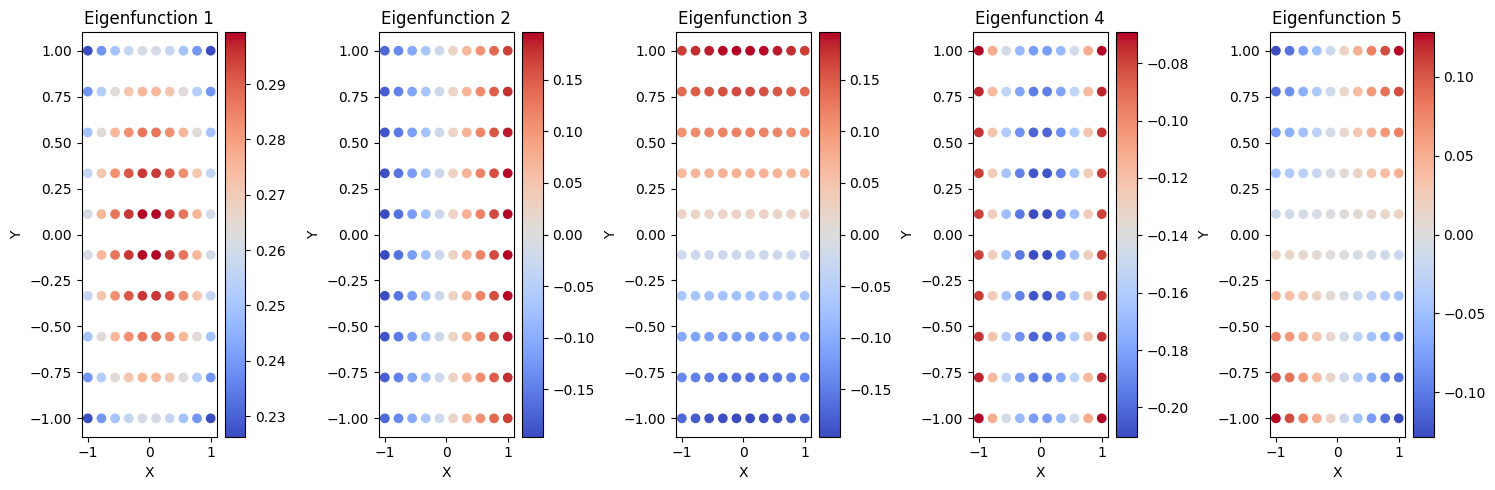

In [5]:
# grids_1d = np.linspace(0, 1, 100).reshape(-1, 1)  # 1D Grid
grids_2d = generate_grids(d = 2, num_grids = 10, grids_lim = (-1, 1), random = False)

print(grids_2d.shape, type(grids_2d))

# eigen_funcs_1d = gp_eigen_funcs_fast(grids_1d)
eigen_funcs_2d = gp_eigen_funcs_fast(grids_2d)

print(eigen_funcs_2d.shape, type(eigen_funcs_2d))

# visualize_gp_eigen_funcs(grids_1d, eigen_funcs_1d)
visualize_gp_eigen_funcs(grids_2d, eigen_funcs_2d)